In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint

In [2]:
bdif = pd.read_excel("bdif_modelo.xlsx")

In [3]:
bdif.shape

(570372, 30)

In [4]:
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


### Aplicamos dummies a las variables categoricas

In [5]:
# Lista de columnas categóricas
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Generar variables dummies y agregarlas directamente al DataFrame
bdif = pd.get_dummies(bdif, columns=categoricas, drop_first=False)

# Seleccionar las columnas dummies y convertirlas a 0 y 1
dummies = bdif.filter(regex='^detectadopor|^combustible|^fuego|^lugar|^mes|^dia|^horario').columns

# Convertir solo esas columnas a 0 y 1
bdif[dummies] = bdif[dummies].astype(int)

# Mostramos el resultado
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,fecha,poblacion,superficie,altitud,lon,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,1974020249,1974,11,2,0.0,1974-04-25,2117.457786,51221.68,878.0,-2.318960,...,0,0,0,0,1,0,0,0,0,1
1,1974020374,1974,11,2,0.0,1974-05-19,26076.005568,77929.12,570.0,-1.703449,...,0,0,1,0,0,0,0,0,0,1
2,1974020459,1974,11,46,0.0,1974-06-11,3790.498405,44668.00,596.0,-1.056085,...,0,0,0,0,1,0,0,1,0,0
3,1974022274,1974,11,2,0.0,1974-09-11,1133.070631,8100.28,1126.0,-2.418393,...,0,1,0,0,1,0,0,0,0,1
4,1974022457,1974,11,2,0.0,1974-10-01,513.556146,14658.96,696.0,-2.070538,...,1,0,0,0,1,0,0,1,0,0


### Aplicamos mapeo de clases a la variable objetivo

In [6]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    334211
1    234195
2      1966
Name: count, dtype: int64

### Normalizamos las variables numéricas

In [7]:
# Seleccionamos las variables numéricas
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
# Cargamos el Standard Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

bdif[numericas] = scaler.fit_transform(bdif[numericas])

# Mostramos el resultado
bdif[numericas].head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,hrmedia,denpoblacion,denincendios,fwi
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,0.541667,0.000166,0.000014,0.068724
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,0.510417,0.001347,0.000006,0.421203
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,0.697917,0.000341,0.000018,0.067092
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,0.614583,0.000563,0.000145,0.256033
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,0.427083,0.000141,0.000076,0.089480


In [8]:
#bdif = bdif_save.copy()

In [9]:
bdif_save = bdif.copy()

### Dataset sin balancear

In [10]:
#X = bdif.drop(['parte', 'año', 'fecha', 'cod_com', 'cod_prov', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis=1)
#y = bdif['claseincendio']

# Selección de características
X = bdif[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
y = bdif['claseincendio']

In [11]:
# Dividimos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Entrenamos el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
# Hacer predicciones y evaluar el modelo
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     66843
           1       0.71      0.59      0.65     46839
           2       0.28      0.01      0.02       393

    accuracy                           0.73    114075
   macro avg       0.58      0.48      0.49    114075
weighted avg       0.73      0.73      0.73    114075



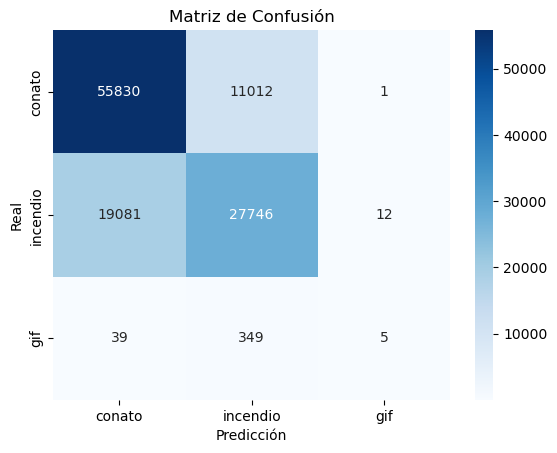

In [14]:
# Matriz de confusión con las clases ordenadas
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Creamos y mostramos la matriz mediante un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Submuestreo preliminar

Lo que hacemos es disiminuir las clases mayoritarias al mismo número de muestras de la clase minoritaria.

In [145]:
# Sin selección de características
# X = bdif.drop(['parte', 'año', 'fecha', 'cod_com', 'cod_prov', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis=1)
# y = bdif['claseincendio']

In [15]:
# Dividir las clases mayoritarias y minoritaria
conatos = bdif[bdif['claseincendio'] == 0]
incendios = bdif[bdif['claseincendio'] == 1]
gif = bdif[bdif['claseincendio'] == 2]

In [16]:
# Submuestrear las clases mayoritarias
conatos_sub = resample(conatos, replace=False,  n_samples=len(gif),  random_state=42)
incendios_sub = resample(incendios,replace=False, n_samples=len(gif), random_state=42)

In [17]:
# Combina las clases balanceadas y la clase minoritaria
bdif_balanced = pd.concat([conatos_sub, incendios_sub, gif])

# Verificar que las clases estén balanceadas
bdif_balanced['claseincendio'].value_counts()

claseincendio
0    1966
1    1966
2    1966
Name: count, dtype: int64

In [27]:
# Selección de características
X = X = bdif[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
y = bdif_balanced['claseincendio']

In [28]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# Entrenar un modelo Random Forest para incendios grandes
rf_sub = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sub.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Predicciones
y_pred = rf_sub.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       393
           1       0.57      0.52      0.54       393
           2       0.77      0.76      0.77       394

    accuracy                           0.66      1180
   macro avg       0.65      0.65      0.65      1180
weighted avg       0.65      0.66      0.65      1180



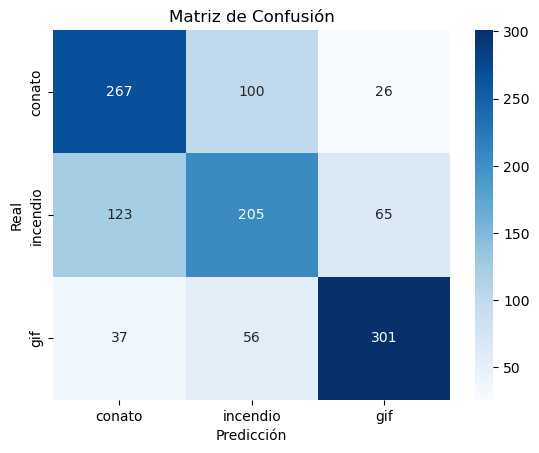

In [31]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

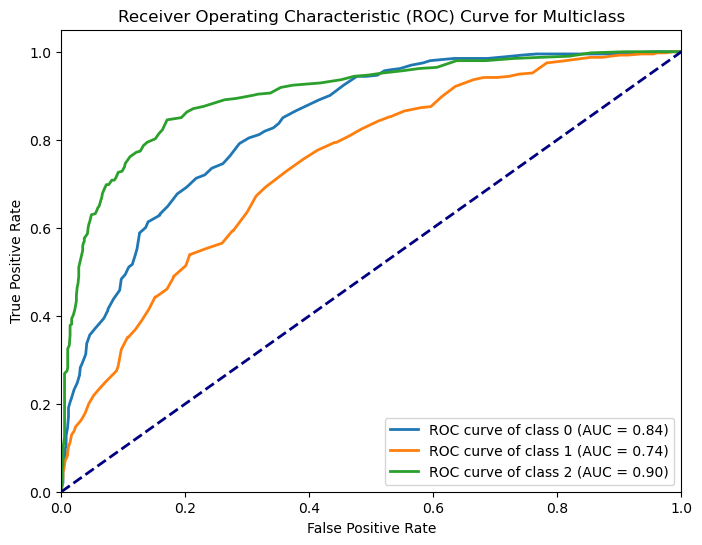

In [32]:
y_pred_prob = rf_sub.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

### Sobremuestreo preliminar

En este caso lo que vamos a hacer es incrementar las clases minoritarias al nivel de la mayoritaria.

In [23]:
# Separamos las variables descriptoras y la variable objetivo
#X = bdif.drop(['parte', 'año', 'fecha', 'cod_com', 'cod_prov', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis=1)
#y = bdif['claseincendio']

# Selección de características
X = bdif[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
y = bdif['claseincendio']

# Dividimos los datos en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sobremuestreo con SMOTE
smote = SMOTE(sampling_strategy={1: len(y_train[y_train == 0]), 2: len(y_train[y_train == 0])}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verificamos la distribución después del sobremuestreo
print("\nDistribución después de hacer sobremuestreo:")
print(pd.Series(y_train).value_counts())
print(f'Las dimensiones del dataset sobremuestreado son: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')


Distribución después de hacer sobremuestreo:
claseincendio
0    267408
1    267408
2    267408
Name: count, dtype: int64
Las dimensiones del dataset sobremuestreado son: (802224, 36)
Tamaño del conjunto de prueba: (114075, 36)


In [24]:
# Entrenar el modelo con los datos balanceados
model_sob = RandomForestClassifier(random_state=42)
model_sob.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# Predicciones y evaluación
y_pred = model_sob.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     66803
           1       0.67      0.66      0.67     46891
           2       0.09      0.13      0.11       381

    accuracy                           0.73    114075
   macro avg       0.51      0.52      0.52    114075
weighted avg       0.73      0.73      0.73    114075



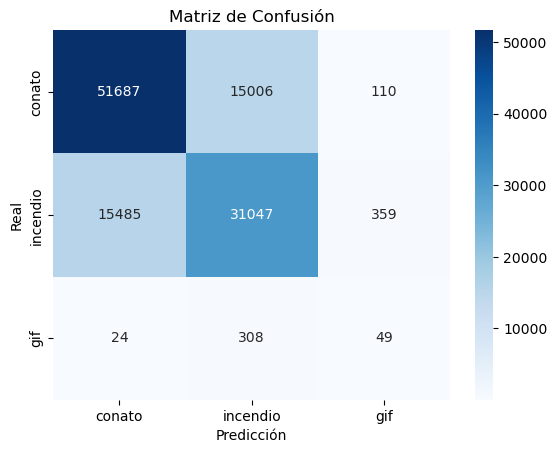

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

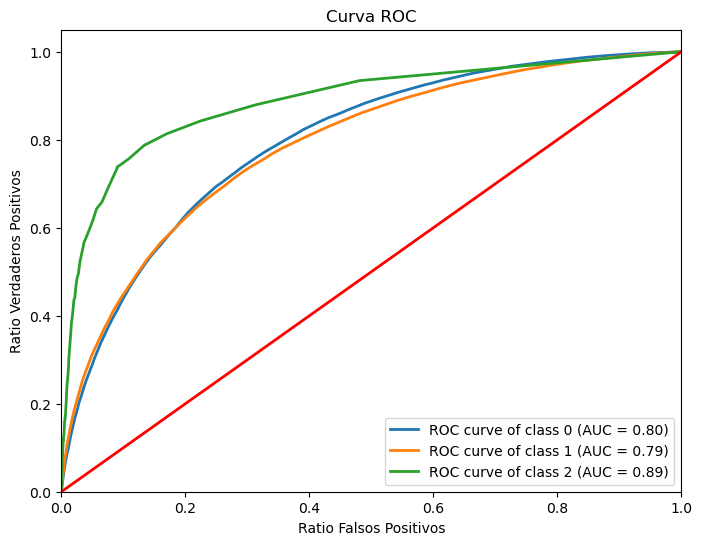

In [27]:
y_pred_prob = model_sob.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()